In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [3]:
#import data into pandas
churn_df = pd.read_csv('churn_data.csv')
customer_df = pd.read_csv('customer_data.csv')
internet_df = pd.read_csv('internet_data.csv')

In [4]:
def df_info(df):
    print('---------------------------------------------------')
    print('Shape\n',df.shape)
    print('---------------------------------------------------')
    print('Colums\n',df.columns)
    print('---------------------------------------------------')
    print('Info\n',df.info())
    print('---------------------------------------------------')
    print('Summary Stats\n',df.describe())
    print('---------------------------------------------------')

In [5]:
#df_info(churn_df)
#df_info(customer_df)
#df_info(internet_df)

In [6]:
#merging the data
df_1 = pd.merge(churn_df,customer_df,how='inner',on='customerID')
data = pd.merge(df_1,internet_df,how='inner',on='customerID')
df_info(data)

---------------------------------------------------
Shape
 (7043, 21)
---------------------------------------------------
Colums
 Index(['customerID', 'tenure', 'PhoneService', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn', 'gender',
       'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies'],
      dtype='object')
---------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Ch

In [7]:
col_list = data.columns
print(col_list)

Index(['customerID', 'tenure', 'PhoneService', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn', 'gender',
       'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies'],
      dtype='object')


In [8]:
#replace space by nan
data['TotalCharges'] = data['TotalCharges'].replace(' ',np.nan)
#convert to float
data['TotalCharges'] = data['TotalCharges'].astype('float64')

In [9]:
col_list_yes_no = []
#convert the Yes/No columns to 1/0 
for i in col_list:    
    temp = data[i].unique()
    if len(temp)==2 and sorted(temp)==['No','Yes']:
        col_list_yes_no.append(i)
        data[i] = data[i].map({'No':0,'Yes':1})
        
print('Yes/No columns\n',col_list_yes_no)        

Yes/No columns
 ['PhoneService', 'PaperlessBilling', 'Churn', 'Partner', 'Dependents']


In [10]:
#creating dummy vars for categorical features
cat_features = ['Contract','PaymentMethod','gender','MultipleLines','InternetService','OnlineSecurity','OnlineBackup',
               'DeviceProtection','TechSupport','StreamingTV','StreamingMovies']

for i in cat_features:    
    #create dummy features
    #print('Creating dummy features for ',i)
    dummy_feature = pd.get_dummies(data[i],prefix=i,drop_first=True)
    
    #add dummy features to main data frame
    #print('Add dummy features to main data frame')
    data = pd.concat([data,dummy_feature],axis=1)
    
    #remove the old feature
    #print('Remove the old feature from main data frame')
    data = data.drop([i],axis=1)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 32 columns):
customerID                               7043 non-null object
tenure                                   7043 non-null int64
PhoneService                             7043 non-null int64
PaperlessBilling                         7043 non-null int64
MonthlyCharges                           7043 non-null float64
TotalCharges                             7032 non-null float64
Churn                                    7043 non-null int64
SeniorCitizen                            7043 non-null int64
Partner                                  7043 non-null int64
Dependents                               7043 non-null int64
Contract_One year                        7043 non-null uint8
Contract_Two year                        7043 non-null uint8
PaymentMethod_Credit card (automatic)    7043 non-null uint8
PaymentMethod_Electronic check           7043 non-null uint8
PaymentMethod_Mailed check        

In [12]:
#cheking for missing values
null_data = round(100*(data.isnull().sum()/len(data.index)), 2)
print(null_data[null_data>0])

TotalCharges    0.16
dtype: float64


In [13]:
'''
There is less than 1% null entries for TotalCharges features, 
we will be removing those rows
'''
data = data[~np.isnan(data['TotalCharges'])]

In [14]:
null_data = round(100*(data.isnull().sum()/len(data.index)), 2)
print(null_data[null_data>0])
print(data.shape)

Series([], dtype: float64)
(7032, 32)


In [15]:
#Standarization for continous value features
df = data[['tenure','MonthlyCharges','TotalCharges']]
#normalizing the features
norm_df=(df-df.mean())/df.std()
#removing old colums
data = data.drop(['tenure','MonthlyCharges','TotalCharges'], 1)
#adding normalized features
data = pd.concat([data,norm_df],axis=1)
data[['tenure','MonthlyCharges','TotalCharges']].head()

,tenure,MonthlyCharges,TotalCharges
0,-1.280157,-1.161611,-0.994123
1,0.064298,-0.260859,-0.173727
2,-1.239416,-0.363897,-0.959581
3,0.512450,-0.747797,-0.195234
4,-1.239416,0.196164,-0.940391


In [16]:
#checking the percentage of positive class
positive_case = (sum(data['Churn'])/data.shape[0])*100
print('Posivtive cases',positive_case)

Posivtive cases 26.578498293515356


### Building the model

In [17]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

rs = 100 #random state value

In [18]:
x = data.drop(['Churn','customerID'],axis=1)
y = data['Churn']

print('x shape',x.shape)
print('y shape',y.shape)

#splitting into train and test sets
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=rs)

x shape (7032, 30)
y shape (7032,)


In [19]:
#We will use the statsmodels package to compute the p-values for the features
#help(sm)
#help(sm.GLM)
logmodel = sm.GLM(y_train,sm.add_constant(x_train),family=sm.families.Binomial())
res = logmodel.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 4922
Model:                            GLM   Df Residuals:                     4898
Model Family:                Binomial   Df Model:                           23
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2004.7
Date:                Fri, 17 May 2019   Deviance:                       4009.4
Time:                        13:52:16   Pearson chi2:                 6.07e+03
No. Iterations:                    20   Covariance Type:             nonrobust
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -2.3056      0.773     -2.984      0.003      -3.820      -0.791
PhoneService                             -0.6775      0.090     -7.495      0.000      -0.855      -0.500
PaperlessBilling                          0.3254      0.090      3.614      0.000       0.149       0.502
SeniorCitizen                             0.3984      0.102      3.924      0.000       0.199       0.597
Partner                                   0.0374      0.094      0.399      0.690      -0.146       0.221
Dependents                               -0.1430      0.107     -1.332      0.183      -0.353       0.067
Contract_One year                        -0.6578      0.129     -5.106      0.000      -0.910      -0.405
Contract_Two year                        -1.2455      0.212     -5.874      0.000      -1.661      -0.830
PaymentMethod_Credit card (automatic)    -0.2577      0.137     -1.883      0.060      -0.526       0.011
PaymentMethod_Electronic check            0.1615      0.113      1.434      0.152      -0.059       0.382
PaymentMethod_Mailed check               -0.2536      0.137     -1.845      0.065      -0.523       0.016
gender_Male                              -0.0346      0.078     -0.442      0.658      -0.188       0.119
MultipleLines_No phone service           -1.6282      0.775     -2.100      0.036      -3.148      -0.108
MultipleLines_Yes                         0.5623      0.214      2.628      0.009       0.143       0.982
InternetService_Fiber optic               2.5124      0.967      2.599      0.009       0.618       4.407
InternetService_No                       -0.3970      0.140     -2.831      0.005      -0.672      -0.122
OnlineSecurity_No internet service       -0.3970      0.140     -2.831      0.005      -0.672      -0.122
OnlineSecurity_Yes                       -0.0245      0.216     -0.113      0.910      -0.448       0.399
OnlineBackup_No internet service         -0.3970      0.140     -2.831      0.005      -0.672      -0.122
OnlineBackup_Yes                          0.1740      0.212      0.822      0.411      -0.241       0.589
DeviceProtection_No internet service     -0.3970      0.140     -2.831      0.005      -0.672      -0.122
DeviceProtection_Yes                      0.3229      0.215      1.501      0.133      -0.099       0.744
TechSupport_No internet service          -0.3970      0.140     -2.831      0.005      -0.672      -0.122
TechSupport_Yes                          -0.0305      0.216     -0.141      0.888      -0.455       0.394
StreamingTV_No internet service          -0.3970      0.140     -2.831      0.005      -0.672      -0.122
StreamingTV_Yes                           0.9598      0.396      2.423      0.015       0.183       1.736
StreamingMovies_No internet service      -0.3970      0.140     -2.831      0.005      -

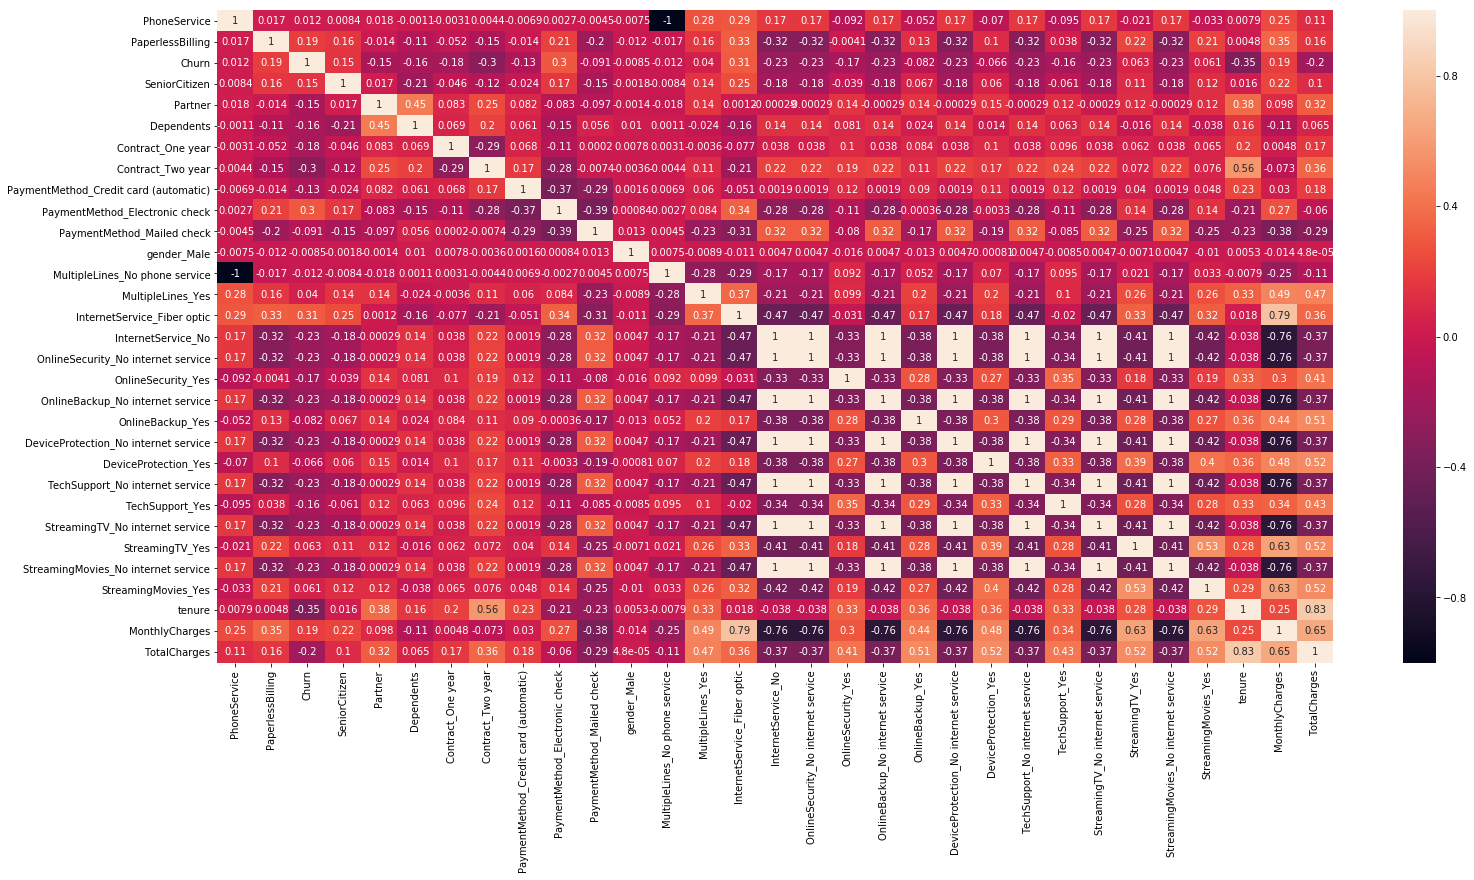

In [20]:
#plot the correlatino matrix
plt.figure(figsize=(25,12))
sns.heatmap(data.corr(),annot=True)

In [53]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [54]:
vif_df = pd.DataFrame()
vif_df['features'] = x.columns
vif_df['vif'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif_df['pvalue'] = [round(i,3) for i in res.pvalues[1:]]

In [56]:
vif_df.sort_values(by='vif',axis=0,ascending=False,inplace=False)

,features,vif,pvalue
15,OnlineSecurity_No internet service,inf,0.005
14,InternetService_No,inf,0.005
25,StreamingMovies_No internet service,inf,0.005
23,StreamingTV_No internet service,inf,0.005
21,TechSupport_No internet service,inf,0.005
19,DeviceProtection_No internet service,inf,0.005
17,OnlineBackup_No internet service,inf,0.005
28,MonthlyCharges,866.089640,0.060
0,PhoneService,354.583951,0.000
11,MultipleLines_No phone service,148.763876,0.036


In [58]:
#Droping variables with high vif val
to_drop = ['OnlineSecurity_No internet service','InternetService_No','StreamingMovies_No internet service',
           'StreamingTV_No internet service','TechSupport_No internet service',
           'DeviceProtection_No internet service','OnlineBackup_No internet service']
x = x.drop(to_drop,axis=1)

#splitting into train and test sets
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=rs)

In [60]:
logmodel = sm.GLM(y_train,sm.add_constant(x_train),family=sm.families.Binomial())
res = logmodel.fit()
#res.summary()

In [61]:
vif_df = pd.DataFrame()
vif_df['features'] = x.columns
vif_df['vif'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif_df['pvalue'] = [round(i,3) for i in res.pvalues[1:]]
vif_df.sort_values(by='vif',axis=0,ascending=False,inplace=False)

,features,vif,pvalue
0,PhoneService,39.378906,0.000
21,MonthlyCharges,22.872213,0.000
22,TotalCharges,10.803153,0.000
11,MultipleLines_No phone service,7.677949,0.002
13,InternetService_Fiber optic,7.658029,0.529
20,tenure,7.583667,0.000
6,Contract_Two year,2.648624,0.000
19,StreamingMovies_Yes,2.458872,0.069
18,StreamingTV_Yes,2.437465,0.374
8,PaymentMethod_Electronic check,1.975617,0.144


In [62]:
### Feature Selection Using RFE

In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn import metrics

In [64]:
logmodel2 = LogisticRegression()
rfe = RFE(logmodel2,12) #select 12 features
rfe = rfe.fit(x,y)

In [67]:
var_selected = x.columns[rfe.support_]
print('Varaibles seleted after RFE\n',var_selected)

Varaibles seleted after RFE
 Index(['PhoneService', 'PaperlessBilling', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Electronic check',
       'MultipleLines_No phone service', 'OnlineSecurity_Yes',
       'OnlineBackup_Yes', 'TechSupport_Yes', 'tenure', 'MonthlyCharges',
       'TotalCharges'],
      dtype='object')


In [69]:
x = x[var_selected]

#splitting into train and test sets
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=rs)
#create new model
logmodel = sm.GLM(y_train,sm.add_constant(x_train),family=sm.families.Binomial())
res = logmodel.fit()
#res.summary()
vif_df = pd.DataFrame()
vif_df['features'] = x.columns
vif_df['vif'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif_df['pvalue'] = [round(i,3) for i in res.pvalues[1:]]
vif_df.sort_values(by='vif',axis=0,ascending=False,inplace=False)

,features,vif,pvalue
11,TotalCharges,10.175889,0.001
9,tenure,6.985588,0.000
0,PhoneService,6.439794,0.000
10,MonthlyCharges,4.263599,0.000
3,Contract_Two year,2.435005,0.000
5,MultipleLines_No phone service,2.094834,0.005
2,Contract_One year,1.544122,0.000
7,OnlineBackup_Yes,1.445349,0.001
8,TechSupport_Yes,1.421193,0.000
6,OnlineSecurity_Yes,1.325378,0.000


In [70]:
#droping feature with high vif value
x = x.drop(['TotalCharges','tenure','PhoneService'],axis=1)

#splitting into train and test sets
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=rs)
#create new model
logmodel = sm.GLM(y_train,sm.add_constant(x_train),family=sm.families.Binomial())
res = logmodel.fit()
#res.summary()
vif_df = pd.DataFrame()
vif_df['features'] = x.columns
vif_df['vif'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif_df['pvalue'] = [round(i,3) for i in res.pvalues[1:]]
vif_df.sort_values(by='vif',axis=0,ascending=False,inplace=False)

,features,vif,pvalue
6,OnlineBackup_Yes,1.968658,0.000
0,PaperlessBilling,1.940919,0.001
7,TechSupport_Yes,1.915891,0.000
5,OnlineSecurity_Yes,1.752394,0.000
8,MonthlyCharges,1.655571,0.000
2,Contract_Two year,1.648581,0.000
3,PaymentMethod_Electronic check,1.500346,0.000
1,Contract_One year,1.382844,0.000
4,MultipleLines_No phone service,1.329664,0.000


In [71]:
#Creating the models
logmodel2 = LogisticRegression()
logmodel2.fit(x_train,y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [75]:
y_pred = logmodel2.predict(x_test) 
#y_pred_prob = logmodel2.predict_proba(x_test) 

In [77]:
confusionmat = metrics.confusion_matrix(y_pred,y_test)
print(confusionmat)

[[1349  297]
 [ 179  285]]


In [79]:
acc = metrics.accuracy_score(y_pred,y_test)
pre = metrics.precision_score(y_pred,y_test)
rec = metrics.recall_score(y_pred,y_test)
f_1 = metrics.f1_score(y_pred,y_test)

print('\nAccuracy :',acc)
print('\nPrecision:',pre)
print('\nRecall   :',rec)
print('\nF1-Score :',f_1)


Accuracy : 0.7744075829383886

Precision: 0.4896907216494845

Recall   : 0.6142241379310345

F1-Score : 0.5449330783938814


In [80]:
def draw_roc(actual,predicted):
    fpr,tpr,threshold = metrics.roc_curve(actual,predicted,drop_intermediate=False)
    auc_score = metrics.roc_auc_score(actual,predicted)
    plt.figure(figsize=(10,10))
    plt.plot(fpr,tpr,label='ROC Curve (Area = %0.2f)'%auc_score)
    plt.plot([0,1],[0,1],'k--')
    plt.xlim([0,1.05])
    plt.xlim([0,1.05])
    plt.xlabel('False +ve Rate')
    plt.ylabel('True +ve Rate')
    plt.title('ROC')
    plt.legend(loc='lower right')
    plt.show()

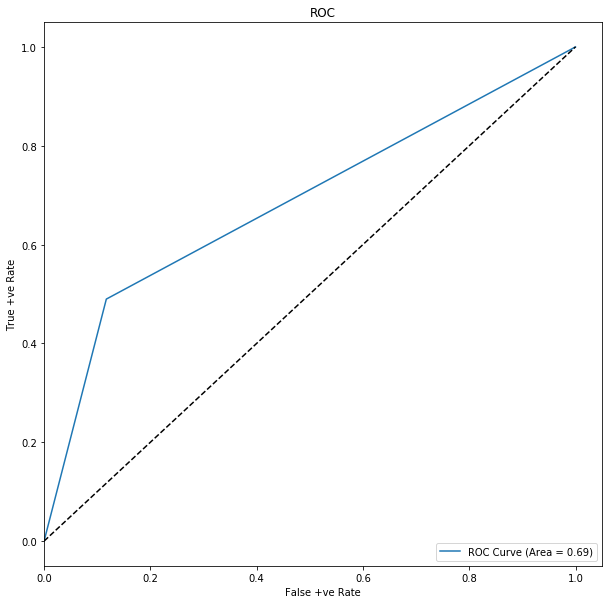

In [81]:
draw_roc(y_test,y_pred)